### HW_lesson_6

#### Задание 1. 
Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn import model_selection
import numpy as np


import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
X, y = load_boston(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

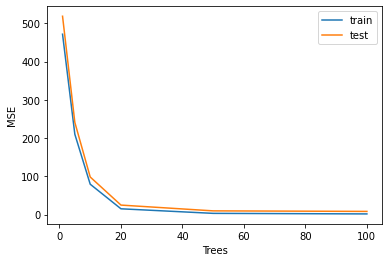

In [8]:
# Построим график зависимости ошибки от количества деревьев в ансамбле
m_trees = [1, 5, 10, 20, 50, 100]
max_depth = 3
eta = 0.1

pl_train = []
pl_test = []

for m_tree in m_trees:
    coefs = [1] * m_tree
    trees, train_errors, test_errors = gb_fit(m_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    pl_train.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    pl_test.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
    
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.plot(m_trees, pl_train, label='train')
plt.plot(m_trees, pl_test, label='test')
plt.legend(loc='upper right')
plt.show()

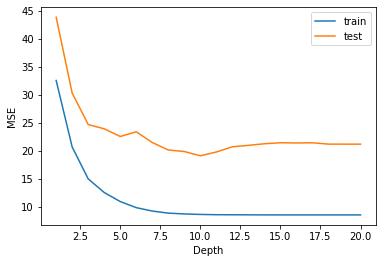

In [9]:
# Построим график зависимости ошибки от максимальной глубины деревьев
m_trees = 20
m_depths = list(range(1, 21))
eta = 0.1

pl_train = []
pl_test = []

for m_depth in m_depths:
    coefs = [1] * m_trees
    trees, train_errors, test_errors = gb_fit(m_trees, m_depth, X_train, X_test, y_train, y_test, coefs, eta)

    pl_train.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    pl_test.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
    
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.plot(m_depths, pl_train, label='train')
plt.plot(m_depths, pl_test, label='test')
plt.legend(loc='upper right')
plt.show()

#### Задание 2. 
Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [10]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    sub_low = 0
    sub_high = X_train.shape[0]
    sub_size = int(X_train.shape[0] * 0.5)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # Генерирууем случайную подвыборку
        sub_ind = np.random.randint(sub_low, sub_high, sub_size)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[sub_ind], y_train[sub_ind])
            train_errors.append(mean_squared_error(y_train[sub_ind], gb_predict(X_train[sub_ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train[sub_ind], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[sub_ind], bias(y_train[sub_ind], target))
            
            train_errors.append(mean_squared_error(y_train[sub_ind], gb_predict(X_train[sub_ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [11]:
def get_error_sgb_plot(n_trees, gb_err, sgb_err, title):
    plt.title(title)
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), gb_err, label='GB error')
    plt.plot(list(range(n_trees)), sgb_err, label='SGB error')
    plt.legend(loc='upper right')
    plt.show()

In [12]:
max_depth = 3
eta = 0.1
n_trees = 20
coefs = [1] * n_trees

In [13]:
%%time
gb_trees, gb_train_errors, gb_test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 10.5 s


In [14]:
%%time
sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 5.69 s


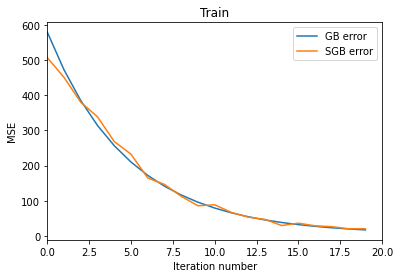

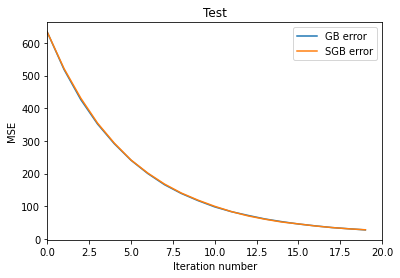

In [15]:
get_error_sgb_plot(n_trees, gb_train_errors, sgb_train_errors, 'Train')
get_error_sgb_plot(n_trees, gb_test_errors, sgb_test_errors, 'Test')